# Imports

In [76]:
# set the New York timezone so that the date parsing is correct
import os, time
os.environ['TZ'] = 'America/New_York'
time.tzset()

In [376]:
# import libraries
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [638]:
# from google.colab import drive

# # Google 드라이브 마운트
# drive.mount('/content/drive')

# 확인할 폴더 경로
df_raw = pd.read_parquet('~/downloads/WAV_total_19to23.parquet', engine = 'pyarrow')

In [639]:
df_raw.head()

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
0,HV0003,B02395,B02395,2019-02-01 00:03:03,2019-02-01 00:12:50,2019-02-01 00:18:17,2019-02-01 00:40:21,18,167,3.46,...,0.00,0.0,NaN,0.0,0.00,N,N,N,Y,None
1,HV0003,B02875,B02875,2019-02-01 00:45:48,2019-02-01 00:50:21,2019-02-01 00:59:23,2019-02-01 01:13:04,79,90,1.54,...,0.66,0.0,NaN,0.0,0.00,N,N,N,Y,None
2,HV0003,B02764,B02764,2019-02-01 00:11:33,2019-02-01 00:11:38,2019-02-01 00:11:46,2019-02-01 00:15:26,7,7,0.84,...,0.73,0.0,NaN,0.0,19.01,N,N,N,Y,None
3,HV0003,B02764,B02764,2019-02-01 00:16:01,2019-02-01 00:16:10,2019-02-01 00:16:12,2019-02-01 00:22:26,7,83,1.15,...,0.78,0.0,NaN,0.0,19.01,N,N,N,Y,None
4,HV0003,B02764,B02764,2019-02-01 00:22:58,2019-02-01 00:23:22,2019-02-01 00:23:28,2019-02-01 00:27:37,129,82,0.97,...,0.59,0.0,NaN,0.0,20.61,N,N,N,Y,None


In [640]:
df_raw.tail()

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
1237192,HV0003,B02764,B02764,2019-05-31 23:14:35,2019-05-31 23:23:59,2019-05-31 23:28:57,2019-05-31 23:47:13,159,20,3.86,...,1.73,0.00,NaN,0.0,28.11,N,N,,Y,
1237193,HV0003,B02871,B02871,2019-05-31 22:51:53,2019-05-31 23:03:55,2019-05-31 23:08:45,2019-05-31 23:24:07,170,68,1.03,...,0.64,2.75,NaN,0.0,15.39,N,N,,Y,
1237194,HV0003,B02765,B02765,2019-05-31 23:36:43,2019-05-31 23:47:43,2019-05-31 23:55:32,2019-06-01 00:31:37,75,193,4.65,...,1.88,2.75,NaN,0.0,39.01,N,N,,Y,
1237195,HV0003,B02875,B02875,2019-05-31 23:20:35,2019-05-31 23:34:22,2019-05-31 23:34:22,2019-06-01 00:05:25,48,168,7.25,...,3.59,2.75,NaN,5.0,48.44,N,N,,Y,
1237196,HV0004,B02800,B03136,2019-05-31 23:11:35,2019-05-31 23:22:41,2019-05-31 23:26:07,2019-05-31 23:40:39,46,51,4.19,...,1.73,0.00,NaN,0.0,0.00,N,N,N,Y,


In [641]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1237197 entries, 0 to 1237196
Data columns (total 24 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   hvfhs_license_num     1237197 non-null  object        
 1   dispatching_base_num  1237197 non-null  object        
 2   originating_base_num  1236653 non-null  object        
 3   request_datetime      1237180 non-null  datetime64[ns]
 4   on_scene_datetime     1237168 non-null  datetime64[ns]
 5   pickup_datetime       1237197 non-null  datetime64[ns]
 6   dropoff_datetime      1237197 non-null  datetime64[ns]
 7   PULocationID          1237197 non-null  int64         
 8   DOLocationID          1237197 non-null  int64         
 9   trip_miles            1237197 non-null  float64       
 10  trip_time             1237197 non-null  int64         
 11  base_passenger_fare   1237197 non-null  float64       
 12  tolls                 1237197 non-null  fl

In [642]:
df_raw.sort_values(by='request_datetime')

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
0,HV0003,B02395,B02395,2019-02-01 00:03:03,2019-02-01 00:12:50,2019-02-01 00:18:17,2019-02-01 00:40:21,18,167,3.46,...,0.00,0.00,NaN,0.0,0.00,N,N,N,Y,None
2,HV0003,B02764,B02764,2019-02-01 00:11:33,2019-02-01 00:11:38,2019-02-01 00:11:46,2019-02-01 00:15:26,7,7,0.84,...,0.73,0.00,NaN,0.0,19.01,N,N,N,Y,None
3,HV0003,B02764,B02764,2019-02-01 00:16:01,2019-02-01 00:16:10,2019-02-01 00:16:12,2019-02-01 00:22:26,7,83,1.15,...,0.78,0.00,NaN,0.0,19.01,N,N,N,Y,None
4,HV0003,B02764,B02764,2019-02-01 00:22:58,2019-02-01 00:23:22,2019-02-01 00:23:28,2019-02-01 00:27:37,129,82,0.97,...,0.59,0.00,NaN,0.0,20.61,N,N,N,Y,None
1,HV0003,B02875,B02875,2019-02-01 00:45:48,2019-02-01 00:50:21,2019-02-01 00:59:23,2019-02-01 01:13:04,79,90,1.54,...,0.66,0.00,NaN,0.0,0.00,N,N,N,Y,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1136405,HV0004,B02800,None,NaT,NaT,2020-11-20 07:44:57,2020-11-20 08:10:13,166,162,4.49,...,1.84,2.75,NaN,0.0,17.45,Y,N,N,Y,N
1137684,HV0004,B02800,None,NaT,NaT,2020-11-22 10:59:15,2020-11-22 11:20:35,113,151,6.39,...,2.06,2.75,NaN,0.0,19.18,Y,N,N,Y,N
1149069,HV0004,B02800,None,NaT,NaT,2020-10-09 04:37:15,2020-10-09 05:18:32,37,1,20.48,...,0.00,0.00,NaN,0.0,36.42,Y,N,N,Y,N
1162444,HV0004,B02800,None,NaT,NaT,2020-10-27 16:08:58,2020-10-27 16:16:29,231,236,0.35,...,2.62,2.75,NaN,0.0,21.20,Y,N,N,Y,N


# Data Formatting

In [643]:
from datetime import datetime, timedelta

df_raw['on_scene_datetime'] = pd.to_datetime(df_raw['on_scene_datetime'])
df_raw['request_datetime'] = pd.to_datetime(df_raw['request_datetime'])
df_raw['waiting_time'] = (df_raw['on_scene_datetime'] - df_raw['request_datetime']).dt.total_seconds()/60 # minute

traindata = df_raw[['pickup_datetime', 'PULocationID','wav_request_flag', 'wav_match_flag', 'waiting_time']]
#tdata = df_raw[['on_scene_datetime','request_datetime', 'waiting_time']]

In [644]:
#tdata.loc[tdata.waiting_time < 0]

In [645]:
taxi_zone_df = pd.read_csv('~/downloads/taxi_zones (1).csv')

traindata2 = pd.merge(df_raw, taxi_zone_df, left_on='PULocationID', right_on='LocationID')
traindata = traindata2[['pickup_datetime', 'PULocationID','wav_request_flag', 'wav_match_flag', 'waiting_time','borough']]


In [646]:
traindata.shape

(1240633, 6)

In [647]:
traindata.head()

,pickup_datetime,PULocationID,wav_request_flag,wav_match_flag,waiting_time,borough
0,2019-02-01 00:18:17,18,Y,None,9.783333,Bronx
1,2019-02-06 12:08:39,18,Y,None,7.933333,Bronx
2,2019-02-06 13:55:07,18,Y,None,2.600000,Bronx
3,2019-02-08 11:39:52,18,Y,None,11.316667,Bronx
4,2019-02-14 15:37:12,18,Y,None,5.233333,Bronx


In [648]:
traindata.tail()

,pickup_datetime,PULocationID,wav_request_flag,wav_match_flag,waiting_time,borough
1240628,2020-06-16 04:53:08,111,Y,Y,6.500000,Brooklyn
1240629,2020-08-24 19:24:35,111,Y,Y,6.366667,Brooklyn
1240630,2023-11-25 17:01:42,111,Y,Y,0.233333,Brooklyn
1240631,2020-08-17 16:26:53,110,Y,Y,8.983333,Staten Island
1240632,2020-08-22 17:46:57,110,Y,Y,19.366667,Staten Island


In [649]:
traindata.PULocationID.isnull().sum()

0

In [650]:
len(traindata.PULocationID.unique())

258

In [651]:
np.sort(traindata.PULocationID.unique())

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 106, 107, 108,
       109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
       135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
       148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
       161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
       174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 18

In [652]:
traindata.pickup_datetime.isnull().sum()

0

In [653]:
traindata.waiting_time.isnull().sum()

29

In [654]:
traindata.loc[traindata['waiting_time'].isna()]

,pickup_datetime,PULocationID,wav_request_flag,wav_match_flag,waiting_time,borough
18333,2020-08-06 23:59:56,7,Y,N,NaN,Queens
126198,2020-05-29 07:57:48,48,Y,Y,NaN,Manhattan
181835,2020-03-25 07:41:00,74,Y,N,NaN,Manhattan
195391,2019-05-30 11:41:37,68,Y,,NaN,Manhattan
204886,2021-03-17 16:12:44,61,Y,Y,NaN,Brooklyn
228832,2020-09-16 13:23:33,225,Y,N,NaN,Brooklyn
270220,2020-11-10 16:05:45,255,Y,N,NaN,Brooklyn
292284,2020-10-27 16:08:58,231,Y,N,NaN,Manhattan
391597,2019-09-11 23:13:32,137,Y,N,NaN,Manhattan
429018,2020-11-17 16:05:40,170,Y,N,NaN,Manhattan


In [655]:
#traindata = traindata.dropna(subset='waiting_time')
values = {"waiting_time":0}
traindata = traindata.fillna(value=values)

In [656]:
traindata.loc[traindata.waiting_time < 0]

,pickup_datetime,PULocationID,wav_request_flag,wav_match_flag,waiting_time,borough
45,2019-04-08 12:37:24,18,Y,None,-4.116667,Bronx
62,2019-04-23 13:35:21,18,Y,None,-6.533333,Bronx
108,2019-07-08 13:26:51,18,Y,,-1.583333,Bronx
206,2019-09-12 11:48:23,18,Y,Y,-1.250000,Bronx
248,2019-10-08 09:59:38,18,Y,Y,-2.200000,Bronx
...,...,...,...,...,...,...
1240542,2023-10-15 10:12:27,44,Y,Y,-8.550000,Staten Island
1240552,2020-01-12 11:21:32,44,Y,Y,-9.416667,Staten Island
1240609,2022-08-10 12:44:31,111,Y,Y,-4.083333,Brooklyn
1240613,2023-02-14 20:11:34,111,Y,Y,-10.366667,Brooklyn


In [657]:
traindata['waitng_time'] = traindata['waiting_time'].apply(lambda x: 0 if x < 0 else x)


In [658]:
traindata.waiting_time.isnull().sum()

0

In [659]:
pickup_counts = df_raw['PULocationID'].value_counts()
print(pickup_counts[0:16])

PULocationID
75     27997
140    21324
42     20335
74     18219
76     17534
244    16833
61     16796
170    16129
216    16094
132    15707
188    15180
26     14809
89     13689
137    12809
107    12184
237    11695
Name: count, dtype: int64


In [660]:
traindata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1240633 entries, 0 to 1240632
Data columns (total 7 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   pickup_datetime   1240633 non-null  datetime64[ns]
 1   PULocationID      1240633 non-null  int64         
 2   wav_request_flag  1240633 non-null  object        
 3   wav_match_flag    1219151 non-null  object        
 4   waiting_time      1240633 non-null  float64       
 5   borough           1240633 non-null  object        
 6   waitng_time       1240633 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 66.3+ MB


In [661]:
print(len(traindata))

1240633


In [662]:
traindata.wav_request_flag.isnull().sum()

0

In [663]:
traindata.wav_match_flag.isnull().sum()

21482

In [664]:
# Select frequent regions
#cond = (traindata['PULocationID']==75) | (traindata['PULocationID']==140) | (traindata['PULocationID']==42) | (traindata['PULocationID']==74) | (traindata['PULocationID']==76) \
#       | (traindata['PULocationID']==244) | (traindata['PULocationID']==61) | (traindata['PULocationID']==170) | (traindata['PULocationID']==216) | (traindata['PULocationID']==132)
# cond = (traindata['PULocationID']==75) | (traindata['PULocationID']==140) | (traindata['PULocationID']==42) | (traindata['PULocationID']==74) | (traindata['PULocationID']==76)
cond = (traindata['borough']=='Manhattan')
traindata = traindata.loc[cond]

In [665]:
traindata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 474148 entries, 5392 to 1233055
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   pickup_datetime   474148 non-null  datetime64[ns]
 1   PULocationID      474148 non-null  int64         
 2   wav_request_flag  474148 non-null  object        
 3   wav_match_flag    465760 non-null  object        
 4   waiting_time      474148 non-null  float64       
 5   borough           474148 non-null  object        
 6   waitng_time       474148 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 28.9+ MB


In [666]:
traindata.head()

,pickup_datetime,PULocationID,wav_request_flag,wav_match_flag,waiting_time,borough,waitng_time
5392,2019-02-01 00:59:23,79,Y,None,4.550000,Manhattan,4.550000
5393,2019-02-01 21:02:53,79,Y,None,2.883333,Manhattan,2.883333
5394,2019-02-07 17:37:24,79,Y,None,4.133333,Manhattan,4.133333
5395,2019-02-09 22:49:11,79,Y,None,7.783333,Manhattan,7.783333
5396,2019-02-10 15:24:02,79,Y,None,2.766667,Manhattan,2.766667


In [667]:
traindata.tail()

,pickup_datetime,PULocationID,wav_request_flag,wav_match_flag,waiting_time,borough,waitng_time
1233051,2020-12-08 18:38:20,120,Y,Y,4.016667,Manhattan,4.016667
1233052,2023-11-16 20:31:18,120,Y,Y,8.133333,Manhattan,8.133333
1233053,2023-11-23 18:00:04,120,Y,Y,5.300000,Manhattan,5.300000
1233054,2023-11-30 20:39:27,120,Y,Y,6.933333,Manhattan,6.933333
1233055,2019-05-29 14:58:32,120,Y,,1.183333,Manhattan,1.183333


In [668]:
from tqdm import tqdm

year = []
month = []
day = []
timestamp = []
for date in tqdm(traindata.pickup_datetime):
    year.append(date.year)
    month.append(date.month)
    day.append(date.day)
    timestamp.append(int(datetime.timestamp(date)))

100%|██████████████████████████████| 474148/474148 [00:00<00:00, 1097618.32it/s]


In [669]:
# converted datetime to timestamp
traindata.insert(0, 'timestamp', timestamp)

In [670]:
# got the month number, which will help in filtering out data while counting
traindata.insert(1, 'month', month)

In [671]:
# got the day number, which will help in filtering out data while counting
traindata.insert(2, 'day', day)

In [672]:
traindata.drop(columns='pickup_datetime', inplace=True)

In [673]:
traindata.head()

,timestamp,month,day,PULocationID,wav_request_flag,wav_match_flag,waiting_time,borough,waitng_time
5392,1549000763,2,1,79,Y,None,4.550000,Manhattan,4.550000
5393,1549072973,2,1,79,Y,None,2.883333,Manhattan,2.883333
5394,1549579044,2,7,79,Y,None,4.133333,Manhattan,4.133333
5395,1549770551,2,9,79,Y,None,7.783333,Manhattan,7.783333
5396,1549830242,2,10,79,Y,None,2.766667,Manhattan,2.766667


In [674]:
traindata.tail()

,timestamp,month,day,PULocationID,wav_request_flag,wav_match_flag,waiting_time,borough,waitng_time
1233051,1607470700,12,8,120,Y,Y,4.016667,Manhattan,4.016667
1233052,1700184678,11,16,120,Y,Y,8.133333,Manhattan,8.133333
1233053,1700780404,11,23,120,Y,Y,5.300000,Manhattan,5.300000
1233054,1701394767,11,30,120,Y,Y,6.933333,Manhattan,6.933333
1233055,1559156312,5,29,120,Y,,1.183333,Manhattan,1.183333


In [675]:
print(len(traindata))

474148


In [676]:
# we need to group by since we will be couting per location
traindataGrouped = traindata.groupby('PULocationID')

In [677]:
traindataGrouped.head()

,timestamp,month,day,PULocationID,wav_request_flag,wav_match_flag,waiting_time,borough,waitng_time
5392,1549000763,2,1,79,Y,None,4.550000,Manhattan,4.550000
5393,1549072973,2,1,79,Y,None,2.883333,Manhattan,2.883333
5394,1549579044,2,7,79,Y,None,4.133333,Manhattan,4.133333
5395,1549770551,2,9,79,Y,None,7.783333,Manhattan,7.783333
5396,1549830242,2,10,79,Y,None,2.766667,Manhattan,2.766667
...,...,...,...,...,...,...,...,...,...
1232938,1553628368,3,26,120,Y,None,21.300000,Manhattan,21.300000
1232939,1554485279,4,5,120,Y,None,2.350000,Manhattan,2.350000
1232940,1554739606,4,8,120,Y,None,27.433333,Manhattan,27.433333
1232941,1560524984,6,14,120,Y,,12.216667,Manhattan,12.216667


In [678]:
print(len(traindataGrouped))

66


In [679]:
print(traindataGrouped.groups)

{4: [583899, 583900, 583901, 583902, 583903, 583904, 583905, 583906, 583907, 583908, 583909, 583910, 583911, 583912, 583913, 583914, 583915, 583916, 583917, 583918, 583919, 583920, 583921, 583922, 583923, 583924, 583925, 583926, 583927, 583928, 583929, 583930, 583931, 583932, 583933, 583934, 583935, 583936, 583937, 583938, 583939, 583940, 583941, 583942, 583943, 583944, 583945, 583946, 583947, 583948, 583949, 583950, 583951, 583952, 583953, 583954, 583955, 583956, 583957, 583958, 583959, 583960, 583961, 583962, 583963, 583964, 583965, 583966, 583967, 583968, 583969, 583970, 583971, 583972, 583973, 583974, 583975, 583976, 583977, 583978, 583979, 583980, 583981, 583982, 583983, 583984, 583985, 583986, 583987, 583988, 583989, 583990, 583991, 583992, 583993, 583994, 583995, 583996, 583997, 583998, ...], 12: [1231576, 1231577, 1231578, 1231579, 1231580, 1231581, 1231582, 1231583, 1231584, 1231585, 1231586, 1231587, 1231588, 1231589, 1231590, 1231591, 1231592, 1231593, 1231594, 1231595, 1231

In [680]:
data = []
i=0
# iterate for each locations
for group_name in tqdm(traindataGrouped.groups.keys()):
    startdate = '2022-12-01 00:00:00';
    startdate = datetime.strptime(startdate, "%Y-%m-%d %H:%M:%S")
    tempdata = traindataGrouped.get_group(group_name)
    while startdate < datetime.strptime('2023-11-30 23:59:59', "%Y-%m-%d %H:%M:%S"):
#        enddate = startdate + timedelta(minutes=60)
        enddate = startdate + timedelta(minutes=60)
        startdate_timestamp = int(datetime.timestamp(startdate))
        enddate_timestamp = int(datetime.timestamp(enddate))
        month = startdate.month
        day = startdate.day
        # filter based on month and day
        tempdata1 = tempdata.loc[(tempdata['month']==month) & (tempdata['day']==day), ['timestamp']]
        # count number of pickups in given 60 minutes
        count = len(tempdata1.query('timestamp >= '+str(startdate_timestamp)+' ' \
                           + 'and timestamp < '+str(enddate_timestamp)))

        df_waiting = tempdata.query('timestamp >= '+str(startdate_timestamp)+' ' \
                           + 'and timestamp < '+str(enddate_timestamp))
        if count == 0:
            avg_waiting_time = 0.0
        else:
            avg_waiting_time = df_waiting['waiting_time'].mean()

        data.append((group_name, startdate_timestamp, count, avg_waiting_time, startdate))
        # update startdate by 15 minutes
        startdate = enddate

100%|███████████████████████████████████████████| 66/66 [15:47<00:00, 14.35s/it]


In [713]:
traindata = pd.DataFrame(data, columns=['location', 'timestamp', 'counts', 'average_waiting_time', 'datetimes'])

traindata['average_waiting_time'] = traindata['average_waiting_time'].apply(lambda x: 0 if x < 0 else x)

# 'average_waiting_time'이 음수인 행을 필터링
negative_waiting_time = traindata[traindata['average_waiting_time'] < 0]

# 결과 출력
print(negative_waiting_time)

Empty DataFrame
Columns: [location, timestamp, counts, average_waiting_time, datetimes]
Index: []


In [714]:
import pandas as pd

# 'timestamp'를 기준으로 그룹화하고, 'counts'와 'average_waiting_time'의 평균을 계산
traindata2 = traindata.groupby('timestamp').agg({'counts': 'mean', 'average_waiting_time': 'mean'}).reset_index()

# 결과 출력
print(traindata2)

traindata.average_waiting_time.isnull().sum()


       timestamp    counts  average_waiting_time
0     1669870800  0.045455              0.204293
1     1669874400  0.015152              0.040152
2     1669878000  0.030303              0.148737
3     1669881600  0.030303              0.106818
4     1669885200  0.015152              0.073737
...          ...       ...                   ...
8754  1701388800  0.454545              1.631692
8755  1701392400  0.272727              1.469571
8756  1701396000  0.227273              1.237753
8757  1701399600  0.318182              1.903072
8758  1701403200  0.166667              0.547348

[8759 rows x 3 columns]


0

In [715]:
print(traindata2)

       timestamp    counts  average_waiting_time
0     1669870800  0.045455              0.204293
1     1669874400  0.015152              0.040152
2     1669878000  0.030303              0.148737
3     1669881600  0.030303              0.106818
4     1669885200  0.015152              0.073737
...          ...       ...                   ...
8754  1701388800  0.454545              1.631692
8755  1701392400  0.272727              1.469571
8756  1701396000  0.227273              1.237753
8757  1701399600  0.318182              1.903072
8758  1701403200  0.166667              0.547348

[8759 rows x 3 columns]


In [716]:
traindata.tail()

,location,timestamp,counts,average_waiting_time,datetimes
578155,263,1701388800,0,0.0,2023-11-30 19:00:00
578156,263,1701392400,0,0.0,2023-11-30 20:00:00
578157,263,1701396000,0,0.0,2023-11-30 21:00:00
578158,263,1701399600,0,0.0,2023-11-30 22:00:00
578159,263,1701403200,0,0.0,2023-11-30 23:00:00


In [717]:
traindata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578160 entries, 0 to 578159
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   location              578160 non-null  int64         
 1   timestamp             578160 non-null  int64         
 2   counts                578160 non-null  int64         
 3   average_waiting_time  578160 non-null  float64       
 4   datetimes             578160 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 22.1 MB


In [718]:
traindata.loc[traindata['average_waiting_time'].isna()]

,location,timestamp,counts,average_waiting_time,datetimes


In [719]:
traindata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578160 entries, 0 to 578159
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   location              578160 non-null  int64         
 1   timestamp             578160 non-null  int64         
 2   counts                578160 non-null  int64         
 3   average_waiting_time  578160 non-null  float64       
 4   datetimes             578160 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 22.1 MB


In [720]:
# traindata.to_csv('~/downloads/traindata.csv', index=False)

In [721]:
# traindata = pd.read_csv('~/downloads/traindata.csv')

In [722]:
traindata.shape
print(traindata2)

       timestamp    counts  average_waiting_time
0     1669870800  0.045455              0.204293
1     1669874400  0.015152              0.040152
2     1669878000  0.030303              0.148737
3     1669881600  0.030303              0.106818
4     1669885200  0.015152              0.073737
...          ...       ...                   ...
8754  1701388800  0.454545              1.631692
8755  1701392400  0.272727              1.469571
8756  1701396000  0.227273              1.237753
8757  1701399600  0.318182              1.903072
8758  1701403200  0.166667              0.547348

[8759 rows x 3 columns]


In [723]:
#cols = list(traindata)[2:4]  # pickup count, waiting time
cols = list(traindata2)[2] # [2]pickup count, [3]waiting time 
tr_data = traindata2[cols].astype(float)

In [724]:
print(tr_data.shape)

(8759,)


In [725]:
print(tr_data)

0       0.204293
1       0.040152
2       0.148737
3       0.106818
4       0.073737
          ...   
8754    1.631692
8755    1.469571
8756    1.237753
8757    1.903072
8758    0.547348
Name: average_waiting_time, Length: 8759, dtype: float64


In [726]:
tr_data.head()

0    0.204293
1    0.040152
2    0.148737
3    0.106818
4    0.073737
Name: average_waiting_time, dtype: float64

In [727]:
#tr_data.loc[tr_data.average_waiting_time < 0]

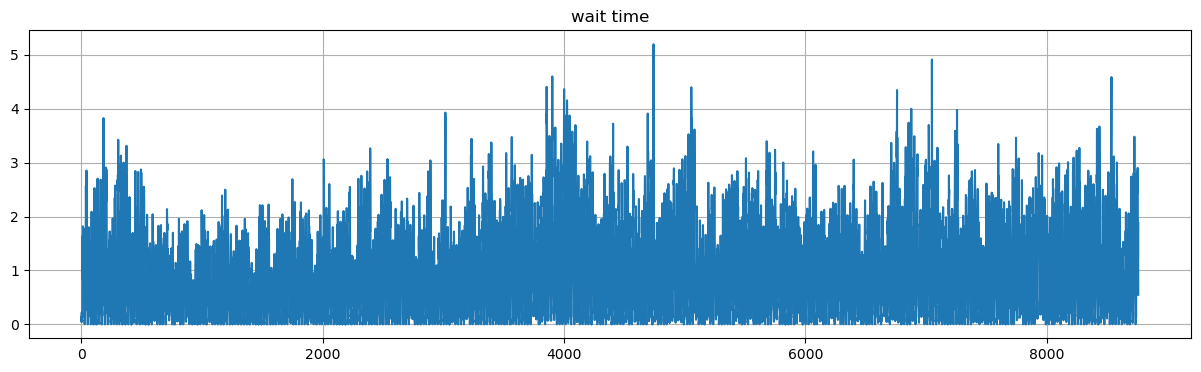

In [728]:
# cols = list(traindata)[2]
# tr_data_counts = reshaped_data[2]

cols = list(traindata2)[2]
tr_data_wait = traindata2[cols].astype(float)

plt.figure(figsize=(15, 4))
plt.title('wait time')
plt.plot(tr_data_wait)
plt.grid()
plt.show()

In [729]:
tr_data = tr_data.rolling(5).mean() #moving average 

print(tr_data)

0            NaN
1            NaN
2            NaN
3            NaN
4       0.114747
          ...   
8754    2.483065
8755    2.210196
8756    1.938348
8757    1.829039
8758    1.357887
Name: average_waiting_time, Length: 8759, dtype: float64


In [730]:
tr_data = tr_data.fillna(value=0)


In [731]:
print(tr_data)

0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.114747
          ...   
8754    2.483065
8755    2.210196
8756    1.938348
8757    1.829039
8758    1.357887
Name: average_waiting_time, Length: 8759, dtype: float64


In [732]:
tr_data = tr_data.apply(lambda x: max(x, 0))


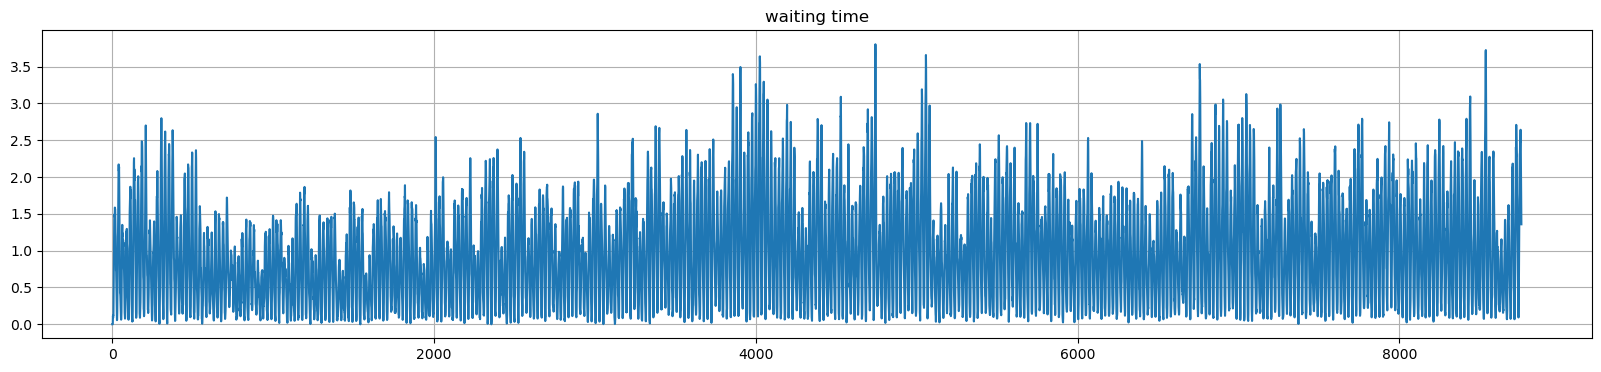

In [733]:
tr_data_wait = tr_data.astype(float)

plt.figure(figsize=(20, 4))
plt.title('waiting time')
plt.plot(tr_data_wait)
plt.grid()
plt.show()

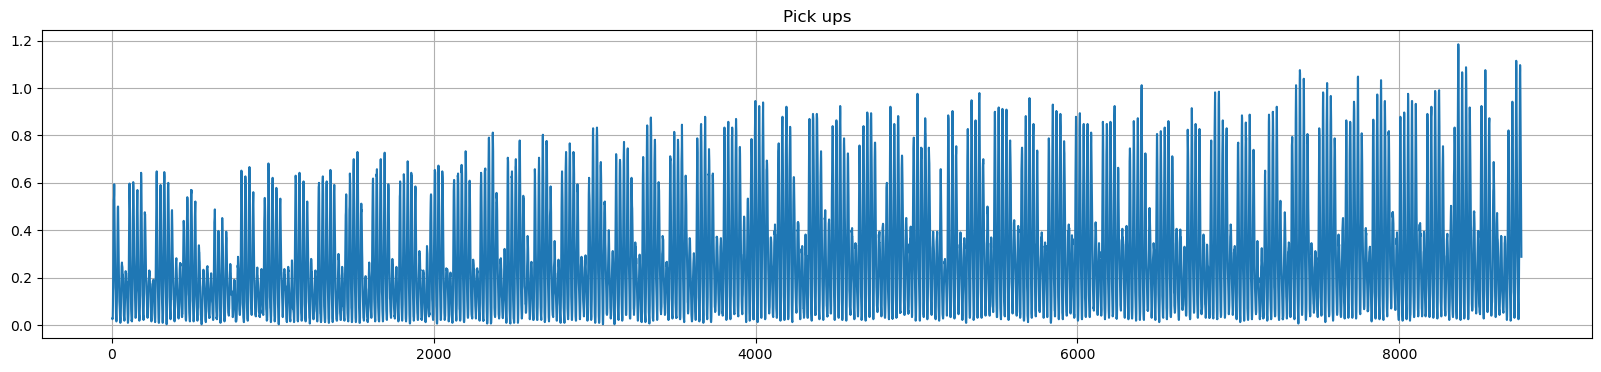

In [734]:
cols = list(traindata2)[1]
tr_data_counts = traindata2[cols].astype(float)
tr_data_counts = tr_data_counts.rolling(5).mean() #moving average 


plt.figure(figsize=(20, 4))
plt.title('Pick ups')
plt.plot(tr_data_counts)
plt.grid()
plt.show()

In [735]:
# separate dates for future plotting
dates = traindata['datetimes']
print(dates)

0        2022-12-01 00:00:00
1        2022-12-01 01:00:00
2        2022-12-01 02:00:00
3        2022-12-01 03:00:00
4        2022-12-01 04:00:00
                 ...        
578155   2023-11-30 19:00:00
578156   2023-11-30 20:00:00
578157   2023-11-30 21:00:00
578158   2023-11-30 22:00:00
578159   2023-11-30 23:00:00
Name: datetimes, Length: 578160, dtype: datetime64[ns]


In [736]:
# normalize the dataset
scaler = StandardScaler()
tr_data = np.expand_dims(tr_data, axis=-1) 
print(tr_data.shape) #(260,timestamp,1)
scaler = scaler.fit(tr_data)
tr_data_scaled = scaler.transform(tr_data)

# split to train data and test data
n_train = int(0.8*tr_data_scaled.shape[0])
train_data_scaled = tr_data_scaled[0: n_train]
train_dates = dates[0: n_train]

test_data_scaled = tr_data_scaled[n_train:]
test_dates = dates[n_train:]
# print(test_dates.head(5))

# data reformatting for LSTM
pred_len = 1  # prediction period
seq_len = 32   # sequence length = past times for future prediction.
input_dim = 1  # input_dimension = ['counts', 'waiting_time']
print(train_data_scaled)

(8759, 1)
[[-1.34482938]
 [-1.34482938]
 [-1.34482938]
 ...
 [ 0.68280895]
 [ 0.35971031]
 [-0.34593077]]


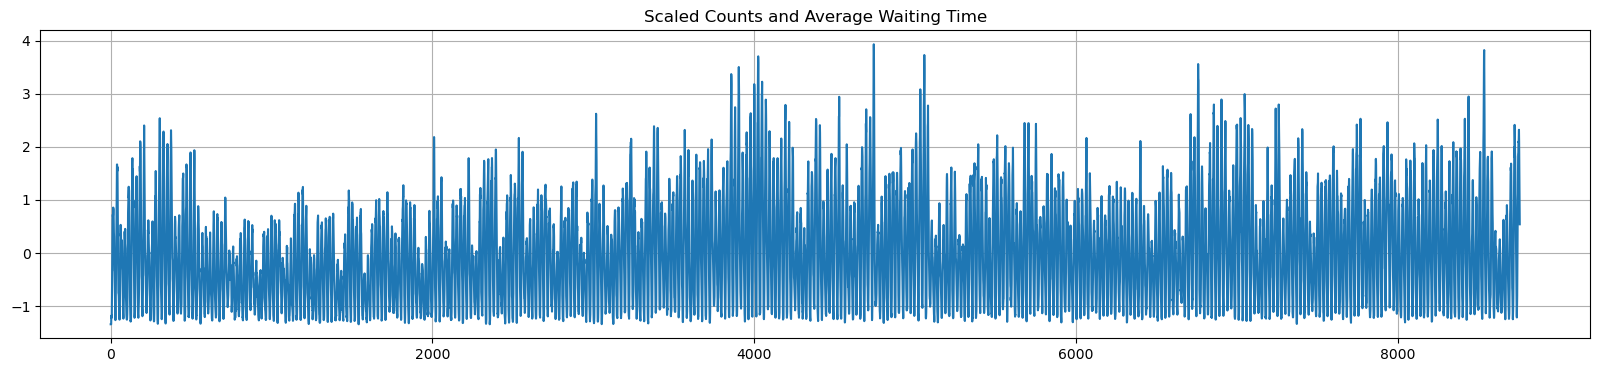

In [737]:
plt.figure(figsize=(20, 4))
plt.title('Scaled Counts and Average Waiting Time')
plt.plot(tr_data_scaled)
plt.grid()
plt.show()

In [738]:
print(n_train-seq_len)

6975


In [739]:
trainX = []
trainY = []
testX = []
testY = []

for i in range(seq_len, n_train-pred_len +1):
    trainX.append(train_data_scaled[i - seq_len:i, 0:train_data_scaled.shape[1]])
    trainY.append(train_data_scaled[i + pred_len - 1:i + pred_len, 0]) # pickup counts
#    trainY.append(train_data_scaled[i + pred_len - 1:i + pred_len, 1]) # waiting time

for i in range(seq_len, len(test_data_scaled)-pred_len +1):
    testX.append(test_data_scaled[i - seq_len:i, 0:test_data_scaled.shape[1]])
    testY.append(test_data_scaled[i + pred_len - 1:i + pred_len, 0]) # pickup counts
#    testY.append(test_data_scaled[i + pred_len - 1:i + pred_len, 1]) # waiting time

trainX, trainY = np.array(trainX), np.array(trainY)
testX, testY = np.array(testX), np.array(testY)

print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(6975, 32, 1) (6975, 1)
(1720, 32, 1) (1720, 1)


In [740]:
print(trainX[20, :, 0])

[ 0.38619055  0.30449446 -0.01302299 -0.33394104 -0.34831469 -0.53387502
 -0.81461696 -0.9735685  -1.11386936 -1.26693121 -1.26328521 -1.10086296
 -0.8004186  -0.65152861 -0.17369236  0.1408335   0.51534306  0.92921656
  1.37647666  1.66867746  1.66801136  1.54440965  1.62250064  1.31683853
  0.69264146  0.45822241  0.17572758 -0.51837952 -0.75677178 -0.76252124
 -0.80788588 -0.91957967]


In [741]:
import tensorflow as tf

drop_rate = 0.3 #0.2~0.3 데이터가 적으면 과적합 되기 쉽기 때문에, 드롭 레이트를 높여야 됨.. 

# LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True)) # (seq length, input dimension)
model.add(tf.keras.layers.Dropout(drop_rate))
model.add(LSTM(128, return_sequences=True))
model.add(tf.keras.layers.Dropout(drop_rate))
model.add(LSTM(128, return_sequences=False))
model.add(tf.keras.layers.Dropout(drop_rate))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(trainY.shape[1]))

model.summary()

# specify your learning rate
learning_rate = 0.0001
# create an Adam optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)
# compile your model using the custom optimizer
model.compile(optimizer=optimizer, loss='mean_absolute_error')
#model.compile(optimizer=optimizer, loss='mse')

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 32, 128)           66560     
                                                                 
 dropout_15 (Dropout)        (None, 32, 128)           0         
                                                                 
 lstm_16 (LSTM)              (None, 32, 128)           131584    
                                                                 
 dropout_16 (Dropout)        (None, 32, 128)           0         
                                                                 
 lstm_17 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 128)              

No weights found, training model from scratch
Epoch 1/100
109/109 [==============================] - 11s 82ms/step - loss: 0.5382 - val_loss: 0.3610
Epoch 2/100
109/109 [==============================] - 9s 87ms/step - loss: 0.3388 - val_loss: 0.3012
Epoch 3/100
109/109 [==============================] - 9s 82ms/step - loss: 0.2976 - val_loss: 0.2724
Epoch 4/100
109/109 [==============================] - 9s 81ms/step - loss: 0.2764 - val_loss: 0.2612
Epoch 5/100
109/109 [==============================] - 9s 80ms/step - loss: 0.2628 - val_loss: 0.2546
Epoch 6/100
109/109 [==============================] - 9s 81ms/step - loss: 0.2568 - val_loss: 0.2388
Epoch 7/100
109/109 [==============================] - 9s 84ms/step - loss: 0.2529 - val_loss: 0.2377
Epoch 8/100
109/109 [==============================] - 9s 87ms/step - loss: 0.2474 - val_loss: 0.2369
Epoch 9/100
109/109 [==============================] - 9s 82ms/step - loss: 0.2427 - val_loss: 0.2311
Epoch 10/100
109/109 [=============

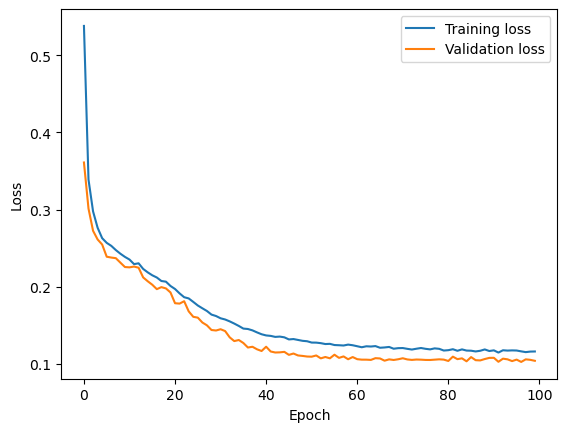

In [742]:
# # Try to load weights
try:
    model.load_weights('/content/drive/MyDrive/filtered_data/lstm_weights.h5')
    print("Loaded model weights from disk")
except:
    print("No weights found, training model from scratch")
    # Fit the model
    history = model.fit(trainX, trainY, epochs=100, batch_size=64,
                    validation_data=(testX, testY), verbose=1)

    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

54/54 [==============================] - 1s 14ms/step
(1720, 1) (1720, 1)
(1720,)
(1720,)


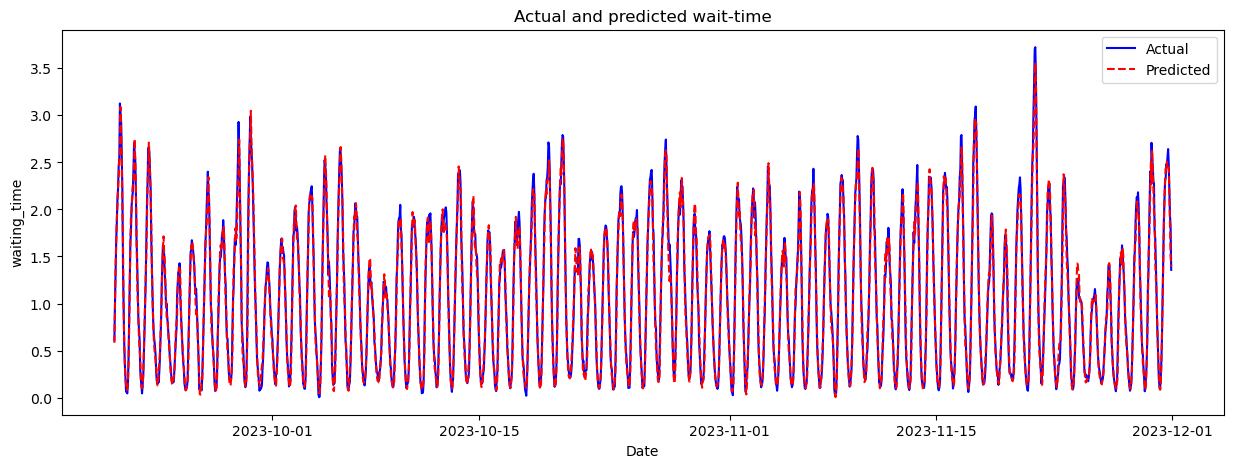

In [745]:
import matplotlib.dates as mdates

# prediction
prediction = model.predict(testX)
print(prediction.shape, testY.shape)

# generate array filled with means for prediction
mean_values_pred = np.repeat(scaler.mean_[np.newaxis, :], prediction.shape[0], axis=0)

# substitute predictions into the first column
mean_values_pred[:, 0] = np.squeeze(prediction)

# inverse transform
y_pred = scaler.inverse_transform(mean_values_pred)[:,0]
print(y_pred.shape)

# generate array filled with means for testY
mean_values_testY = np.repeat(scaler.mean_[np.newaxis, :], testY.shape[0], axis=0)

# substitute testY into the first column
mean_values_testY[:, 0] = np.squeeze(testY)

# inverse transform
testY_original = scaler.inverse_transform(mean_values_testY)[:,0]
print(testY_original.shape)

# plotting
plt.figure(figsize=(15, 5))

midpoint = len(y_pred)

# plot actual vs predicted
plt.plot(test_dates[seq_len:seq_len+midpoint], testY_original[:midpoint], color='blue', label='Actual')
plt.plot(test_dates[seq_len:seq_len+midpoint], y_pred[:midpoint], color='red', linestyle='--', label='Predicted')
plt.xlabel('Date')
plt.ylabel('waiting_time')
plt.title('Actual and predicted wait-time')


# # Set x-axis major ticks to weekly interval and format date display
# ax = plt.gca()
# ax.xaxis.set_major_locator(mdates.MonthLocator())
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d'))

# # Rotate and align the tick labels so they look better
# plt.gcf().autofmt_xdate()



plt.legend()
plt.show()

571153 1720 1720


Text(0.5, 0, 'Date')

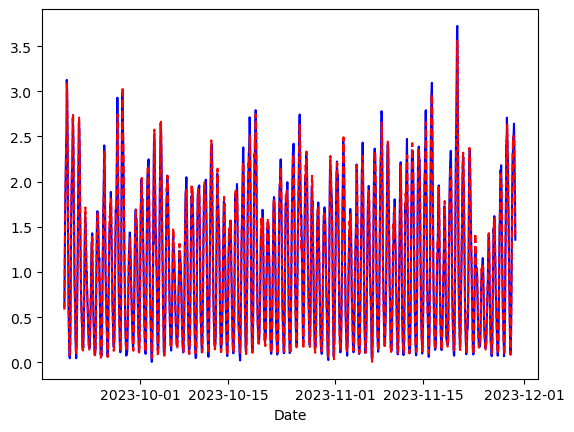

In [746]:
# 예시: 길이를 확인하고 조정
print(len(test_dates), len(testY_original), len(y_pred))

# 가정: 모든 데이터의 길이를 동일하게 맞추기 위한 조정
# 길이가 가장 작은 값으로 모두 조정
min_length = min(len(test_dates), len(testY_original), len(y_pred))

# 데이터 슬라이싱을 min_length에 맞추어 조정
plt.plot(test_dates[:min_length], testY_original[:min_length], color='blue', label='Actual')
plt.plot(test_dates[:min_length], y_pred[:min_length], color='red', linestyle='--', label='Predicted')
plt.xlabel('Date')


In [747]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
mae = mean_absolute_error(testY_original, y_pred)
mse = mean_squared_error(testY_original, y_pred)
rmse = np.sqrt(mse)
r_square = r2_score(testY_original, y_pred)

# 결과 출력
print("Mean Squared Error :", mse)
print("Mean Absolute Error :", mae)
print("Root Mean Squared Error :", rmse)
print("R^2 :",r_square)



Mean Squared Error : 0.010358684297884009
Mean Absolute Error : 0.07475849471401239
Root Mean Squared Error : 0.10177762179322136
R^2 : 0.9823769522561625
